<div align="right">
    <a href="https://colab.research.google.com/github/Its-Shivanshu-Sharma/AdversarialAttacks/blob/main/Adversarial_Attacks.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
    </a>
</div>
    
<div align="right">
    <a href="https://console.paperspace.com/github/Its-Shivanshu-Sharma/AdversarialAttacks/blob/main/Adversarial_Attacks.ipynb">
        <img src="https://assets.paperspace.io/img/gradient-badge.svg" alt="Run on Gradient"/>
    </a>
</div>

# Adversarial Attacks on Neural Networks

---

## Table of Contents:
- ### [Installing & Importing packages, libraries, etc](#installing-&-importing-packages,-libraries,-etc)
- ### [Fetching & preparing the Dataset](#fetching-&-preparing-the-dataset)

<a name="installing-&-importing-packages,-libraries,-etc"></a>

---
## Installing & Importing packages, libraries, etc

### Installing packages

In [126]:
%%bash
pip3 install -qq torch==1.10.2+cu113 torchvision==0.11.3+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

### Importing packages, libraries, etc

In [127]:
import os
from pathlib import Path
import copy
import time
from functools import reduce

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset

In [128]:
# Setting setting the seed for the RNG (Random Number Generator)
# for reproducibility
torch.manual_seed(1234)

<a name="fetching-&-preparing-the-dataset"></a>

---
## Fetching & preparing the Dataset

We'll creating a model for binary classification using the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [129]:
%%bash
# Create a new directory to store the dataset
mkdir pets_dataset
cd pets_dataset
wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz
tar -xf annotations.tar.gz

mkdir: cannot create directory ‘pets_dataset’: File exists


In [130]:
dataset_dir = Path("./pets_dataset")

In [131]:
def ls(path):
    for f in path.iterdir():
        print(f"{'d' if f.is_dir() else 'f': <4}{f}")

In [132]:
ls(dataset_dir)

f   pets_dataset/images.tar.gz.1
d   pets_dataset/images
f   pets_dataset/images.tar.gz
f   pets_dataset/annotations.tar.gz
f   pets_dataset/annotations.tar.gz.1
d   pets_dataset/annotations


In [133]:
full_data = pd.read_csv(
    dataset_dir / "annotations" / "list.txt",
    skiprows=6,
    header=None,
    names=["file_name", "class_id", "species", "breed_id"],
    sep=" ",
)
full_data.head()

file_name  class_id  species  breed_id
0  Abyssinian_100         1        1         1
1  Abyssinian_101         1        1         1
2  Abyssinian_102         1        1         1
3  Abyssinian_103         1        1         1
4  Abyssinian_104         1        1         1

In [134]:
full_data = full_data.loc[:, ["file_name", "species"]]
full_data.head()

file_name  species
0  Abyssinian_100        1
1  Abyssinian_101        1
2  Abyssinian_102        1
3  Abyssinian_103        1
4  Abyssinian_104        1

#### Change the labels (i.e. `species`) for:
- From `Cat = 1` to `Cat = 0` &
- From `Dog = 2` to `Dog = 1`

In [135]:
full_data.loc[:, "species"] = full_data.loc[:, "species"].apply(lambda x: 0 if x == 1 else 1)

In [136]:
full_data.head()

file_name  species
0  Abyssinian_100        0
1  Abyssinian_101        0
2  Abyssinian_102        0
3  Abyssinian_103        0
4  Abyssinian_104        0

In [137]:
def train_val_split(data, train_size=None, val_size=None):
    """Function to randomly split data into training & validation sets
    Parameters:
    -----------
     - data (pandas.DataFrame): Dataframe containing the annotations for the images.
    - train_size (float) - Fraction of data to be allocated to training set.
    - val_size (float) - Fraction of data to be allocated to test set.
                         (`val_size` is ignored if `train_size` is not None)

    Returns:
    --------
    A tuple containing Dataframes for the training and validation sets,
    i.e. returns `(train_set, val_set)`.
    """
    size = len(data)
    # Calculate length of the training set
    if train_size:
        train_len = int(train_size * size)
    elif val_size:
        train_len = size - int(val_size * size)

    # Randomly generate training and validation datasets
    idxs = torch.randperm(size)
    train_set = data.iloc[idxs[:train_len], :].reset_index(drop=True)
    val_set = data.iloc[idxs[train_len:], :].reset_index(drop=True)

    return train_set, val_set

In [138]:
data = {}
data["train"], data["val"] = train_val_split(full_data, train_size=0.8)

In [139]:
data["train"].head()

file_name  species
0  staffordshire_bull_terrier_174        1
1                       beagle_73        1
2                  Abyssinian_192        0
3    american_pit_bull_terrier_93        1
4   american_pit_bull_terrier_119        1

#### Create `Dataset` objects for the training & validations sets

In [140]:
class PetsDataset(Dataset):
    """Custom defined Dataset subclass for working with the IIIT-Pets Dataset"""

    def __init__(
        self,
        annotations,
        img_dir,
        img_format="jpg",
        transform=None,
        target_transform=None,
    ):
        """
        Parameters:
        -----------
        - annotations (pandas.DataFrame) - Dataframe containing the annotations.
        - img_dir (str or Path object) - Path to the directory containing images.
        - img_format (str: default = 'jpg') - Format of the images.
        - transform (callable; default=None) - Tranformation to apply to images.
        - target_transform (callable; default=None) - Transformation to apply to
                                                      target labels.
        """
        self.annotations = annotations
        self.img_dir = img_dir
        self.img_format = img_format
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        file_name = self.annotations.iloc[index, 0] + "." + self.img_format
        img_file = os.path.join(self.img_dir, file_name)
        image = torchvision.io.read_image(img_file)
        label = self.annotations.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### **Note:** Some images have an additional `alpha` channel for transparency.<br>This will cause problems, hence, we will simply remove this additional channel using the `resize_remove` tranform on the images.

In [141]:
def resize_remove(img_size):
    """This function will resize the image to the passed size using
    `torchvision.transforms.functional.resize` and will keep only the
    first `img_size[0]` number of channels.

    Parameters:
    -----------
    - img_size (tuple or array-like) - specifies the size (channels, height, width)
                                       to which the image must be resized.
    Returns:
    --------
    A callable that will resize the image & remove extra channels.
    """
    num_channels = img_size[0]

    def transform(img):
        return TF.resize(img[:num_channels], img_size[1:])

    return transform

In [142]:
def scale_image(img, min=0, max=255):
    """Function to perform minmax scaling on an image and convert its type to 
    float.

    Parameters:
    -----------
    - img (Tensor) : Image to scale.
    - min (int) : Minimum value to use.
    - max (int): Maximum value to use.

    Returns:
    --------
    Scaled tensor (image).
    """
    img = img.float()
    img = (img - min)/(max - min)

    return img

In [143]:
# Define the image size in (C, H, W) format
img_size = (3, 150, 150)

In [158]:
# Define the mean and variance to use for Normalization
img_mean = torch.Tensor([0.485, 0.456, 0.406])
img_std = torch.Tensor([0.229, 0.224, 0.225])

In [159]:
data_transforms = {
    "train": T.Compose([
        resize_remove(img_size),
        scale_image,
        T.Normalize(img_mean, img_std),
    ]),
    "val": T.Compose([
        resize_remove(img_size),
        scale_image,
        T.Normalize(img_mean, img_std),
    ]),
}

In [160]:
datasets = {
    phase: PetsDataset(
        data[phase], img_dir=dataset_dir / "images", transform=data_transforms[phase]
    )
    for phase in ["train", "val"]
}

In [161]:
dataset_sizes = {phase: len(datasets[phase]) for phase in ["train", "val"]}

### Visualizing the Data

In [173]:
def visualize_data(data, label_map, n_rows=3, n_cols=3):
    """Function to display n_rows * n_cols number of images of the passed `data`.

    Parameters:
    -----------
    - data (Dataset or its subclass): Data which has to be visualized.
    - label_map (dict): Mapping from int to labels for the classes.
    - n_rows (int): Number of rows of images to display.
    - n_cols (int): Number of columns of images to display.
    """
    figure = plt.figure(figsize=(8, 8))
    # Randomly choose the images to display from the data
    idxs = torch.randint(high=len(data), size=(n_rows * n_cols,)).tolist()

    for i, idx in enumerate(idxs):
        img, label = data[idx]
        figure.add_subplot(n_rows, n_cols, i + 1)
        plt.title(label_map.get(label))
        plt.axis("off")
        # Denormalize the pixel values
        img = img * img_std.view(-1, 1, 1) + img_mean.view(-1, 1, 1)
        plt.imshow(img.permute((1, 2, 0)))  # change image to (H,W,C) format
    plt.show()

In [174]:
labels = {
    0: "Cat",
    1: "Dog",
}

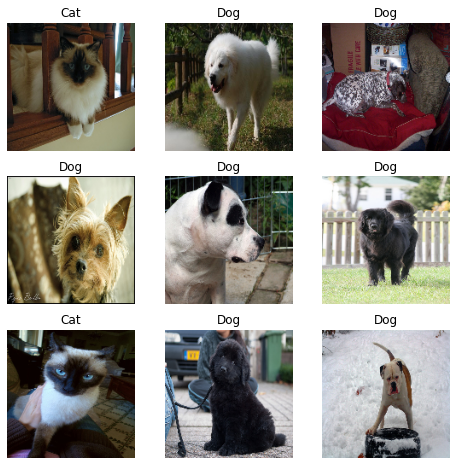

In [175]:
visualize_data(datasets["train"], labels)

#### Create `DataLoader` objects for the training & validation data

In [176]:
# define the batch size
bs = 32

In [177]:
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=bs, shuffle=True) for phase in ["train", "val"]
}

<a name="training-a-deep-neural-network-for-binary-classification"></a>

---
## Training a Deep Neural Network for Binary Classification

In this section we will be training a simple `Feed-Forward Neural Network` on our pets dataset.<br> The output of the network will be one of the 2 classes, i.e. `Cat` or `Dog`.

In [178]:
class FeedForwardNetwork(nn.Module):
    """A class defining a simple Feedforward neural network"""

    def __init__(self, img_size):
        """
        Parameters:
        -----------
        - img_size: Dimensions of the input image.
        """
        super(FeedForwardNetwork, self).__init__()
        input_size = reduce(lambda x, y: x * y, img_size)

        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.sequential(x)

In [179]:
def train_val_model(
    model,
    dataloaders,
    dataset_sizes,
    loss_fn,
    optimizer,
    num_epochs,
    threshold=0.5,
    device="cpu",
):
    """
    Parameters:
    -----------
    - dataloaders (dict-like): dict containing dataloader objects for the
                               training & validation datasets.
    - dataset_sizes (dict-like): dict containing the lengths for the training &
                                validation datasets.
    - model: The model which has to be trained (& used for making predictions).
    - loss_fn (function): Loss function to use for calculating the gradients
    - optimizer: Optimizer to use for updating the parameters of the model
    - num_epochs (int): Number of epochs for which the model must be trained.
    - theshold (float; default=0.5): Value above which the image will be
                                     considered to belong to class `1`.
    - device (str; default="cpu"): Device to use for training the model.

    Returns:
    --------
    Dictionary containing the parameters of the model which had the best accuracy
    on the validation set.
    """
    start_time = time.time()

    # Initialize the best model weights as the initial weights of the model
    best_model_parameters = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Move the `model` to the specified `device`
    model = model.to(device)

    # Initially set the gradients to zero
    optimizer.zero_grad()

    for i in range(num_epochs):
        print(f"Epoch {i}/{num_epochs-1}")
        print("-" * 30)

        # Both the training & validation datasets are passed to the model in
        # each epoch
        for phase in ["train", "val"]:
            # Set mode depending upon the phase
            if phase == "train":
                model.train()
            else:
                model.eval()

            total_loss = 0.0
            total_corrects = 0

            with torch.set_grad_enabled(phase == "train"):
                for imgs, targets in dataloaders[phase]:
                    imgs = imgs.float().to(device)
                    targets = targets.float().unsqueeze(1).to(device)
                    predictions = model(imgs)
                    loss = loss_fn(predictions, targets)
                    total_loss += loss.item() * imgs.size(0)
                    total_corrects += torch.sum(
                        (predictions > threshold) == targets
                    )

                    # Update parameter values during the training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        # Set the gradients to zero
                        optimizer.zero_grad()

            avg_loss = total_loss / dataset_sizes[phase]
            accuracy = total_corrects / dataset_sizes[phase]
            print(f"{phase.capitalize()} Average Loss: {avg_loss: .4f}")
            print(f"{phase.capitalize()} Accuracy: {accuracy: .4f}")

            if phase == "val" and accuracy > best_accuracy:
                best_model_parameters = copy.deepcopy(model.state_dict())
                best_accuracy = accuracy
        # Print a new line after each epoch
        print()

    total_time = time.time() - start_time
    print(f"Model training completed in {total_time//60}m {total_time % 60}s")
    print(f"Best validation set accuracy: {best_accuracy}")

    return best_model_parameters

### Create, train & validate model

##### Use `GPU` for training if available else use `CPU`

In [180]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device being used: {device}")

Device being used: cuda


In [181]:
model = FeedForwardNetwork(img_size)
num_epochs = 10
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
bce_loss = nn.BCELoss()

In [182]:
best_parameters = train_val_model(model, dataloaders, dataset_sizes, bce_loss, optimizer, num_epochs, device=device)

Epoch 0/9
------------------------------
Train Average Loss:  0.6691
Train Accuracy:  0.5952
Val Average Loss:  0.6497
Val Accuracy:  0.6197

Epoch 1/9
------------------------------
Train Average Loss:  0.6076
Train Accuracy:  0.6749
Val Average Loss:  0.6161
Val Accuracy:  0.6605

Epoch 2/9
------------------------------
Train Average Loss:  0.5871
Train Accuracy:  0.6928
Val Average Loss:  0.5981
Val Accuracy:  0.6871

Epoch 3/9
------------------------------
Train Average Loss:  0.5653
Train Accuracy:  0.7039
Val Average Loss:  0.6125
Val Accuracy:  0.6619

Epoch 4/9
------------------------------
Train Average Loss:  0.5529
Train Accuracy:  0.7147
Val Average Loss:  0.5944
Val Accuracy:  0.6803

Epoch 5/9
------------------------------
Train Average Loss:  0.5212
Train Accuracy:  0.7297
Val Average Loss:  0.5976
Val Accuracy:  0.6884

Epoch 6/9
------------------------------
Train Average Loss:  0.4876
Train Accuracy:  0.7563
Val Average Loss:  0.6271
Val Accuracy:  0.6673

Epoch 

---
# Creating Adversarial Examples

In [387]:
def show_adversarial_example(x, x_adv, clean_pred, adv_pred, labels, epsilon, threshold=0.5):
    clean_pred = clean_pred.squeeze().item()
    adv_pred = adv_pred.squeeze().item()
    
    clean_label = labels[int(clean_pred > threshold)]
    clean_probability = clean_pred if clean_pred > threshold else 1 - clean_pred
    adv_label = labels[int(adv_pred > threshold)]
    adv_probability = adv_pred if adv_pred > threshold else 1 - adv_pred

    fig, axs = plt.subplots(1, 3, figsize=(18, 8))

    x = x.detach().to("cpu")
    x_adv = x_adv.detach().to("cpu")
    noise = x_adv - x

    # Denormalize the pixel values
    x = torch.clip(x * img_std.view(-1, 1, 1) + img_mean.view(-1, 1, 1), 0, 1)
    x_adv = torch.clip(x_adv * img_std.view(-1, 1, 1) + img_mean.view(-1, 1, 1), 0, 1)

    # Scale the noise such that it lies between 0 & 1
    noise = torch.clip(( ( (noise) / epsilon ) / 2 ) + 0.5, 0, 1)

    # Change image dimension from (C,H,W) to (H,W,C)
    x = x.permute((1, 2, 0))
    x_adv = x_adv.permute((1, 2, 0))
    noise = noise.permute((1, 2, 0))

    axs[0].imshow(x)
    axs[0].set_title("Clean Example", fontsize=20)
    axs[0].axis("off")
    axs[0].text(0.5, -0.1, f"Prediction:{clean_label}\nProbability = {clean_probability}", size=15, ha="center", transform=axs[0].transAxes)
    axs[0].text(1.1, 0.5, "+", size=20, ha="center", transform=axs[0].transAxes)

    axs[1].imshow(noise)
    axs[1].set_title("Noise", fontsize=20)
    axs[1].axis("off")
    axs[1].text(1.1, 0.5, "=", size=20, ha="center", transform=axs[1].transAxes)

    axs[2].imshow(x_adv)
    axs[2].set_title("Adversarial Example", fontsize=20)
    axs[2].axis("off")
    axs[2].text(0.5, -0.1, f"Prediction:{adv_label}\nProbability = {adv_probability}", size=15, ha="center", transform=axs[2].transAxes)

    plt.show()

---
## Fast Gradient Sign Method

Fast Gradient Sign Method is very fast and computationally efficient method for generating adversarial examples.

Mathematically,
$$
X^{adv} = X + \epsilon \times sign \left(\nabla_{X} J \left(X,\;Y_{true} \right)\right) \\
$$
Here,

$ X = $ Original (clean) input image

$ X^{adv} = $ Adversarial example

$ \epsilon = $ Magnitude of adversarial perturbation

$ \nabla J \left(X,\;Y_{true} \right) = $ Gradient of the loss function w.r.t the input image $ X $

In [388]:
def generate_fgsm_example(x, y, epsilon, model, loss_fn, device="cpu"):
    # Set the model to evaluation mode
    model.eval()
    x_adv = x.detach().clone().float().unsqueeze(0).to(device).requires_grad_()
    y_target = torch.Tensor([y]).unsqueeze(1).to(device)
    y_pred = model(x_adv)
    loss = loss_fn(y_pred, y_target)
    loss.backward()
    x_adv = x_adv + epsilon * torch.sign(x_adv.grad)

    return x_adv.squeeze(0)

In [401]:
epsilon = 0.25
bce_loss = nn.BCELoss()

In [402]:
x, y = datasets["val"][1]

In [403]:
x_adv = generate_fgsm_example(x, y, epsilon, model, bce_loss, device=device)

In [404]:
clean_pred = model(x.unsqueeze(0).float().to(device))
adv_pred = model(x_adv.unsqueeze(0).to(device))

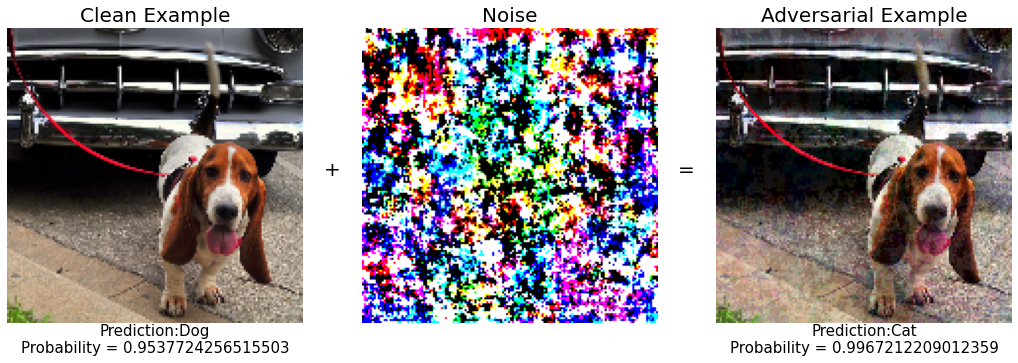

In [405]:
show_adversarial_example(x, x_adv, clean_pred, adv_pred, labels, epsilon=epsilon)

### Tradeoff between confidence in predictions & visual distortion

In [413]:
epsilons = [0.01, 0.025, 0.08, 0.15, 0.25, 0.8]

For epsilon = 0.01


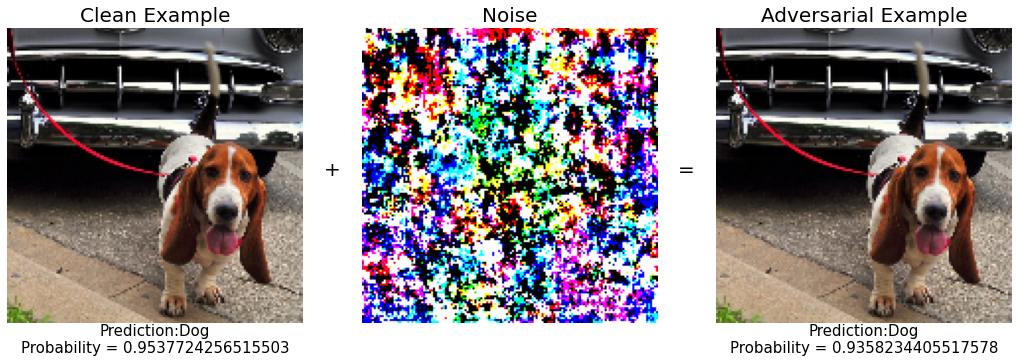

For epsilon = 0.025


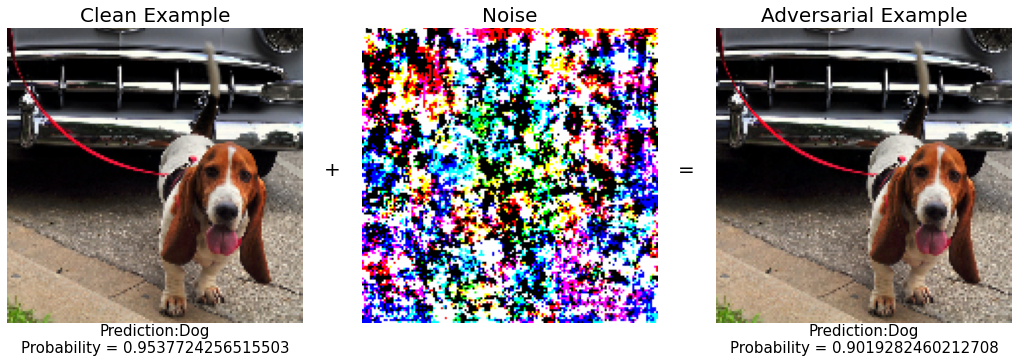

For epsilon = 0.08


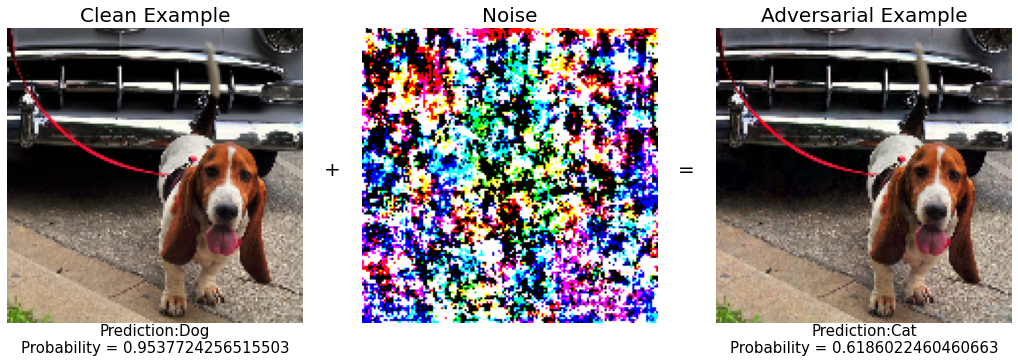

For epsilon = 0.15


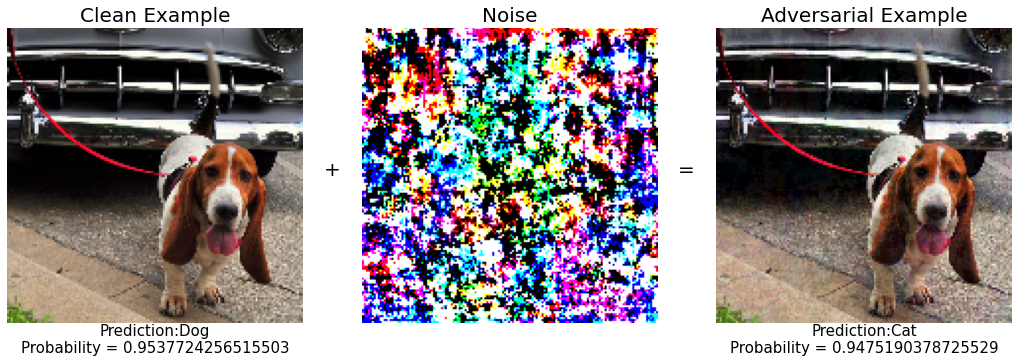

For epsilon = 0.25


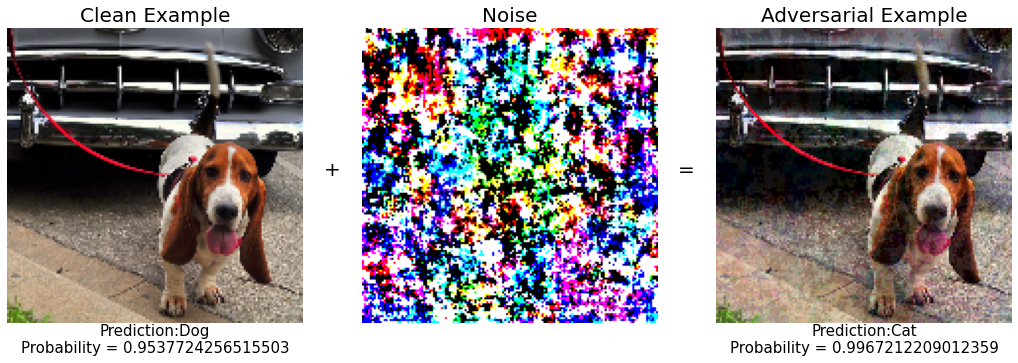

For epsilon = 0.8


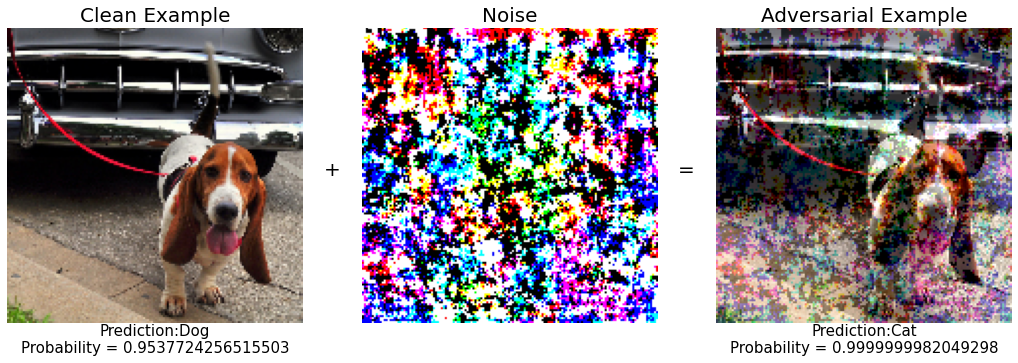

In [414]:
for epsilon in epsilons:
    print(f"For epsilon = {epsilon}")
    x_adv = generate_fgsm_example(x, y, epsilon, model, bce_loss, device=device)
    clean_pred = model(x.unsqueeze(0).float().to(device))
    adv_pred = model(x_adv.unsqueeze(0).to(device))
    show_adversarial_example(x, x_adv, clean_pred, adv_pred, labels, epsilon=epsilon)

---
## Basic Iterative Method

Basic Iterative Method is an extension of Fast Gradient Sign Method. It consists of applying the FGSM method multiple times.

Mathematically,
$$
X^{adv}_{0} = X \\
X^{adv}_{N+1} = Clip_{X, \epsilon} \left( X^{adv}_{N} + \alpha \times sign \left( \nabla_{X^{adv}_{N}} J \left( X^{adv}_{N},\;Y_{true} \right)\right) \right)\\
$$
Here,

$ X = $ Original (clean) input image

$ X^{adv} = $ Adversarial example

$ \epsilon = $ Magnitude of adversarial perturbation

$ \nabla J \left(X,\;Y_{true} \right) = $ Gradient of the loss function w.r.t the input image $ X $

$ Clip_{X, \epsilon} $ denotes clipping of the input in the range $ \left[ X - \epsilon,\; X + \epsilon \right] $

In [406]:
def generate_bim_example(x, y, epsilon, alpha, num_epochs, model, loss_fn, device="cpu"):
    # Set the model to evaluation mode
    model.eval()
    x_adv = x.detach().clone().float().unsqueeze(0).to(device).requires_grad_()
    y_target = torch.Tensor([y]).unsqueeze(1).to(device)
    x_adv_min = x.detach().clone().float().unsqueeze(0).to(device) - epsilon
    x_adv_max = x.detach().clone().float().unsqueeze(0).to(device) + epsilon
    
    for i in range(num_epochs):
        y_pred = model(x_adv)
        loss = loss_fn(y_pred, y_target)
        loss.backward()
        x_adv.data = x_adv.data + alpha * torch.sign(x_adv.grad)
        x_adv.data = torch.clip(x_adv.data, x_adv_min, x_adv_max)

    return x_adv.squeeze(0)

In [407]:
epsilon = 0.25
alpha = 0.025
num_epochs = 10
bce_loss = nn.BCELoss()

In [408]:
x, y = datasets["val"][1]

In [409]:
x_adv = generate_bim_example(x, y, epsilon, alpha, num_epochs, model, bce_loss, device=device)

In [410]:
clean_pred = model(x.unsqueeze(0).float().to(device))
adv_pred = model(x_adv.unsqueeze(0).to(device))

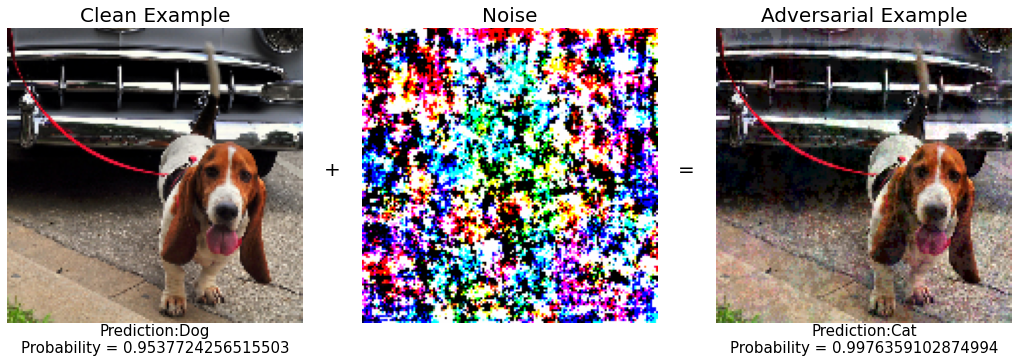

In [411]:
show_adversarial_example(x, x_adv, clean_pred, adv_pred, labels, epsilon=epsilon)